# **Energizing Insights: Predictive Analytics for Electricity Consumption with Weather and Holiday Data Integration**

This project is an exploration into the intricate dynamics of electricity usage patterns, influenced by an array of factors including weather conditions and public holidays. Leveraging data from the UC Irvine Machine Learning Repository, along with comprehensive weather and holiday datasets, we embark on a journey to dissect, analyze, and predict electricity consumption patterns.

# Discovery, preparation and control of data

In [1]:
# Used Version of Python : Python 3.11.0
# pip install numpy pandas matplotlib seaborn plotly colorama scikit-learn xgboost statsmodels missingno tqdm

In [2]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

# Data manipulation
import numpy as np
import pandas as pd

# Set pandas display options
pd.set_option('display.max_columns', None)  # Display all columns
pd.set_option('display.max_rows', 4)        # Maximum number of rows to 4

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from colorama import Fore

# Set seaborn color palette and matplotlib style
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

# Machine Learning
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

# XGBoost
import xgboost as xgb

# Statistical models
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Utilities
from datetime import datetime, date
import math
import os
import re

# Data missingness visualization
import missingno as msno

# Progress bar
from tqdm import tqdm

# Importing data
We have done the import work for you. But feel free to import any other library if needed !

This first step aims at importing the dataset with only few of its original fields and type variables appropriately

In [3]:
# Data source
DATA_SOURCE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
# Import data
consumptions = pd.read_csv(
    # Define the source
    DATA_SOURCE_URL,
    # Set separator
    sep =';',
    # Column names location
    header=0,
    # NA flag
    na_values='?',
    # Retain only a few columns
    usecols = ['Date','Time', 'Global_active_power'],
    # Type definition
    dtype={
        'Date':str,
        'Time':str,
        'Global_active_power':np.float64
    },
    # Date inference is not required
    infer_datetime_format=False
)

# Standardise column names using lower case
consumptions.rename(
    columns = {
        'Date':'date',
        'Time':'time',
        'Global_active_power':'total_consumption'
        },
    inplace=True
)
# Define the dataframe index based on the timestamp (date-time)
consumptions.index = pd.to_datetime(
    consumptions.date + "-" + consumptions.time,
    format = "%d/%m/%Y-%H:%M:%S"
)
# Drop the date and time variables that are now redondant with the index
consumptions.drop(columns=['date', 'time'], inplace=True)
# Color mapping for graphs
serie = ("total_consumption", "grey")

# We resample for you to continue the exercise
consumptions_df = consumptions.resample('D').sum()
consumptions_df.tail(2)

total_consumption
2010-11-25           1431.164
2010-11-26           1488.104

# Discovery and Analysis

### 📈 Time Series Data

**Time series data** represents observations collected sequentially over time, each marked at predefined intervals 🕒. 

Examples for ecample include electricity usage 💡. Such data is pivotal for businesses to identify patterns, trends, and seasonal variations . However, modeling time series data introduces unique challenges due to its inherent randomness and seasonal fluctuations.

**Types of Time Series Data**
Understanding timely patterns/characteristics in data are becoming very critical aspect in analyzing and describing trends in business data 

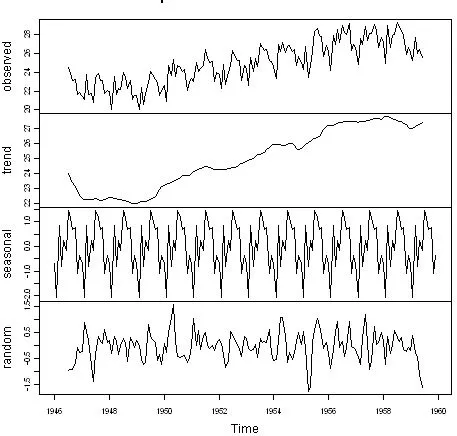>

Depending on the type of time series, there may be an optimal approach to use. What matters most in time series analysis is the forecast horizon. Generally, the farther into the future we aim to predict, the more challenging it becomes.

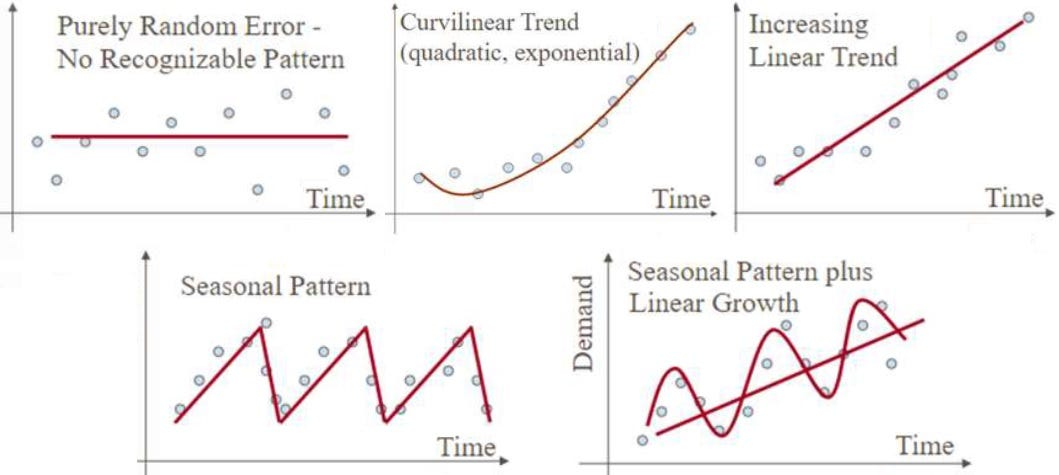

## 1. Data visualization 

In [4]:
# Viz the dataframe head 
consumptions_df.head(2)

total_consumption
2006-12-16           1209.176
2006-12-17           3390.460

In [5]:
# Viz the dataframe tail 
consumptions_df.tail(2)

total_consumption
2010-11-25           1431.164
2010-11-26           1488.104

In [6]:
# Print the Column names
consumptions_df.columns

Index(['total_consumption'], dtype='object')

> Only one column is present, and it's the target. We should perform additional feature engineering to augment this data before proceeding with machine learning.

In [7]:
print(consumptions_df.shape)
consumptions_df.info()

(1442, 1)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1442 entries, 2006-12-16 to 2010-11-26
Freq: D
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   total_consumption  1442 non-null   float64
dtypes: float64(1)
memory usage: 22.5 KB


> We have a total of **1442** records over the time! 

## Understanding the Pattern of Missingness

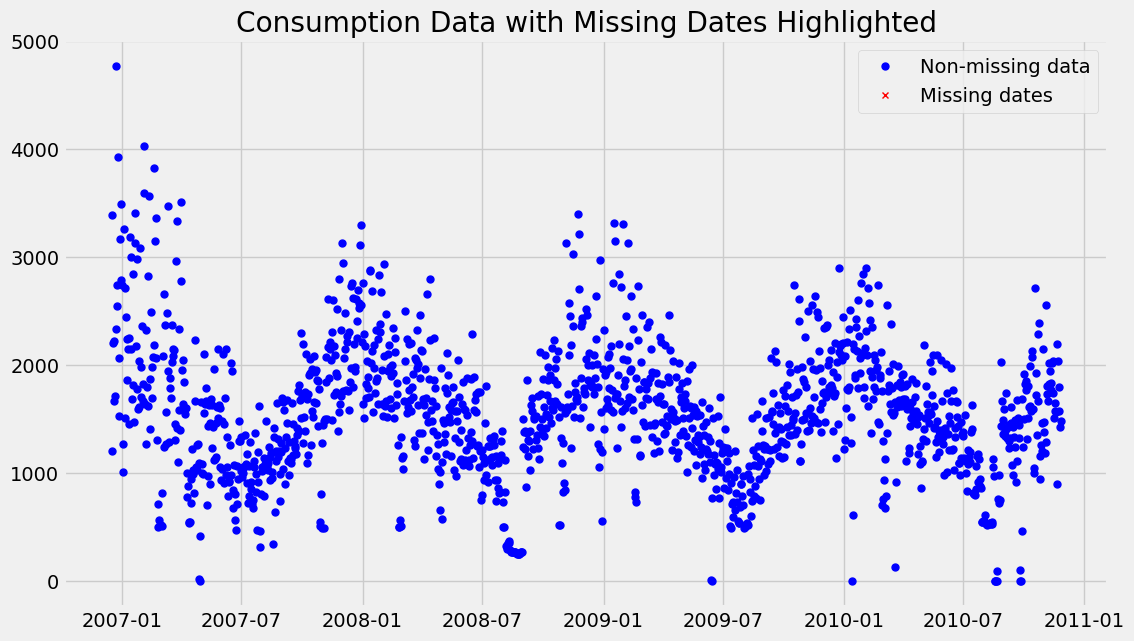

In [8]:
# Create a complete date range from min to max of the original index
complete_date_range = pd.date_range(start=consumptions_df.index.min(), end=consumptions_df.index.max())

# Reindex the DataFrame to this complete range, introducing NaNs for missing dates
consumptions_df_reindexed = consumptions_df.reindex(complete_date_range)

plt.figure(figsize=(12, 7))

# Plot non-missing data points from original data
plt.plot(consumptions_df.index[~consumptions_df['total_consumption'].isnull()], 
         consumptions_df['total_consumption'].dropna(), 
         'o', markersize=5, label='Non-missing data', color='blue')

# Identify and plot the missing dates (where total_consumption is NaN due to reindexing)
missing_dates = consumptions_df_reindexed['total_consumption'].isnull()
plt.plot(consumptions_df_reindexed.index[missing_dates], 
         [np.nan] * missing_dates.sum(), 
         'x', markersize=5, label='Missing dates', color='red')

plt.title('Consumption Data with Missing Dates Highlighted')
plt.legend()
plt.show()

> In this code, we plotted the records that we have in blue. We also generated the `complete_date_range` to encompass the full date range. If there is any date within this range that is missing, we will plot it as a red 'x' point on the date. As we can see, if there are no red points, it means there are no missing dates—all is good.

## 2. Data Analysis

### 2.1. Augmented Dickey-Fuller (ADF) test for stationarity

**`The ADF statistic`** is a test statistic that measures the degree of stationarity in the data, while **`the p-value`** is the probability of observing the ADF statistic by chance if the null hypothesis of non-stationarity is true. 

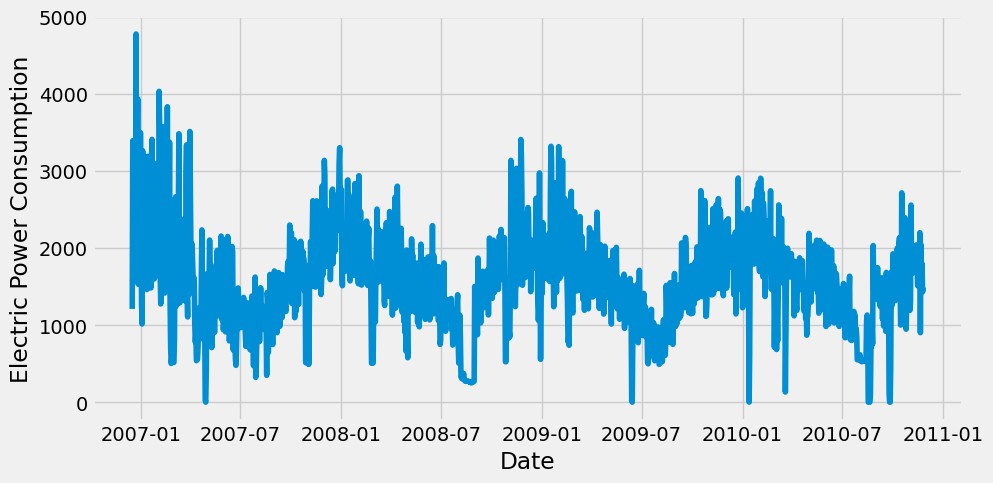

ADF Statistic: -3.849776942163352
p-value: 0.002437177429858372


In [9]:
# Create a copy of the dataframe
consumptions_df1 = consumptions_df.copy()

# Rename the index to 'Date'
consumptions_df1.index.name = 'Date'

# Plot the original data
plt.figure(figsize=(10,5))
plt.xlabel('Date')
plt.ylabel('Electric Power Consumption')
plt.plot(consumptions_df1['total_consumption'])
plt.show()

# ADF test for stationarity
adf_result = adfuller(consumptions_df1['total_consumption'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

> In this case, **the ADF statistic is -3.85**, and **the p-value is 0.002**, which indicates that the null hypothesis of non-stationarity can be rejected at a significance level of 0.05. This suggests that the 'total_consumption' data is stationary. Overall, this output shows that the 'total_consumption' data is **stationary**, and can be used for further analysis, such as time series forecasting or modeling.

### 2.2. Analyzing Weekly and Monthly Variations in Electricity Usage Patterns

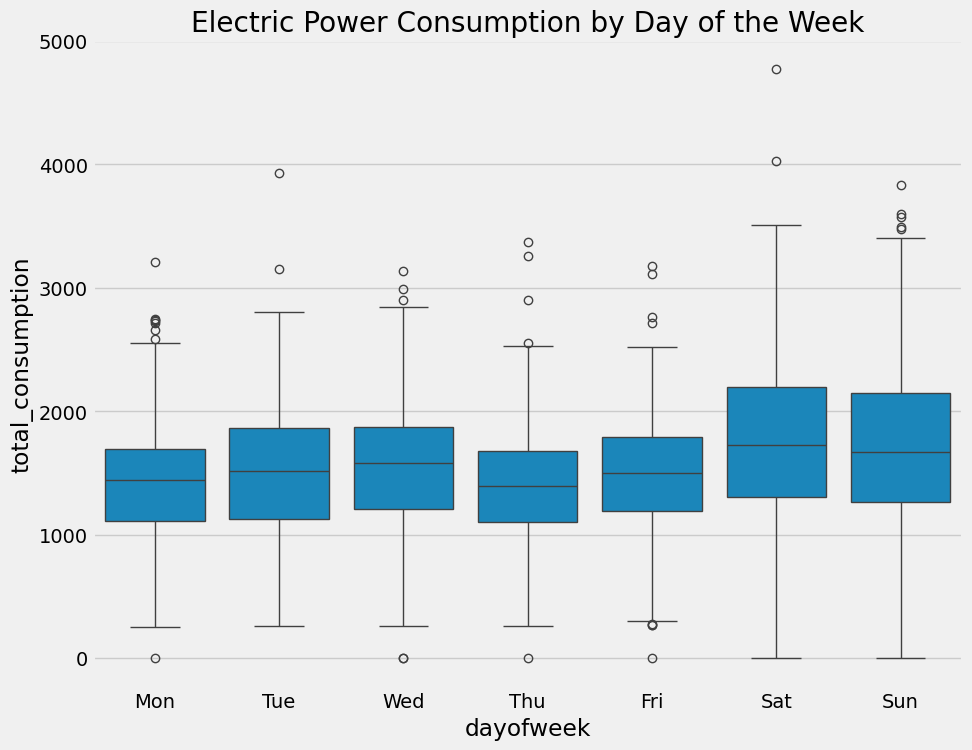

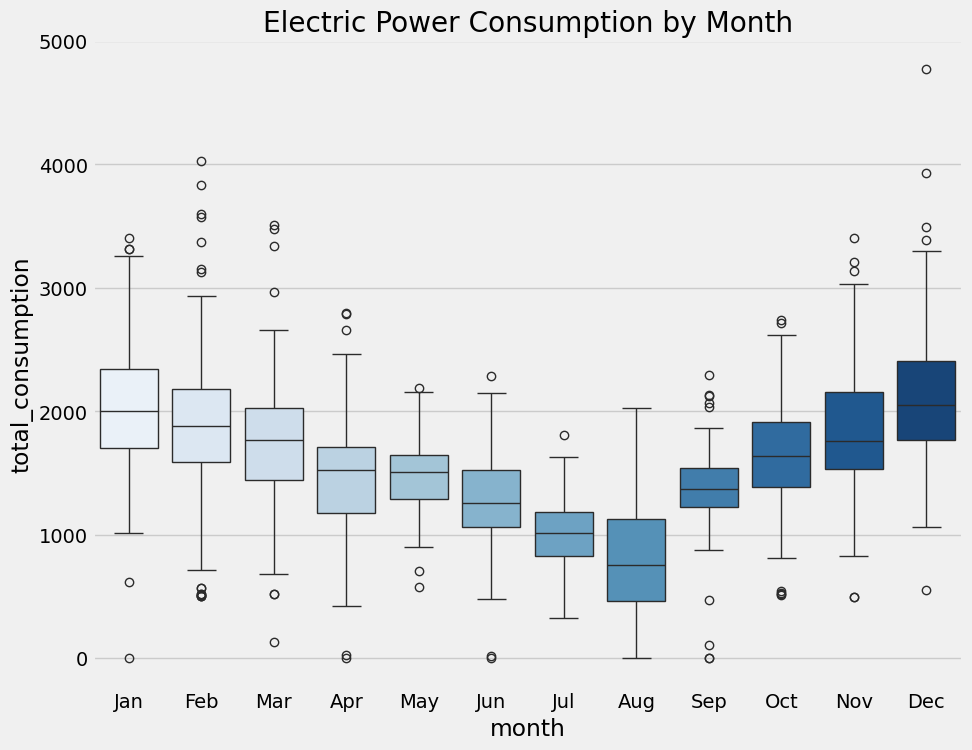

In [10]:
def create_features(df):    
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    return df

consumptions_df = create_features(consumptions_df)

# Visualize Electric Power Consumption by Day of the Week
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=consumptions_df, x='dayofweek', y='total_consumption')
ax.set_title('Electric Power Consumption by Day of the Week')
plt.xticks(ticks=range(7), labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()

# Visualize Electric Power Consumption by Month
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=consumptions_df, x='month', y='total_consumption', palette='Blues')
ax.set_title('Electric Power Consumption by Month')
plt.xticks(ticks=range(12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

## Interpretation of the Boxplots for Electric Power Consumption Insights

Based on the provided boxplots, we can deduce the following insights about electric power consumption:

### Weekly Trends
- Consumption is consistent during weekdays.
- Weekends show higher variability, indicating fluctuating usage.

### Monthly Trends
- Spring months (Mar-May) exhibit lower power usage.
- A noticeable increase in consumption starts from June, peaking towards December.
- Colder months show significant outliers, suggesting sporadic peaks in consumption.

### Implications for Feature Engineering
> The discernible impact of time-related factors on energy consumption implies that temporal features are crucial and should be included during the feature engineering phase to predict power usage effectively.

#### **Exploring Consumption Data from UC Irvine Machine Learning Repository**

Based on the provided link, let's delve deeper and understand this data. Perhaps we can enhance the processing! 🤞

Upon visiting the UC Irvine Machine Learning Repository, which is the source of the consumption data, we have the following information:

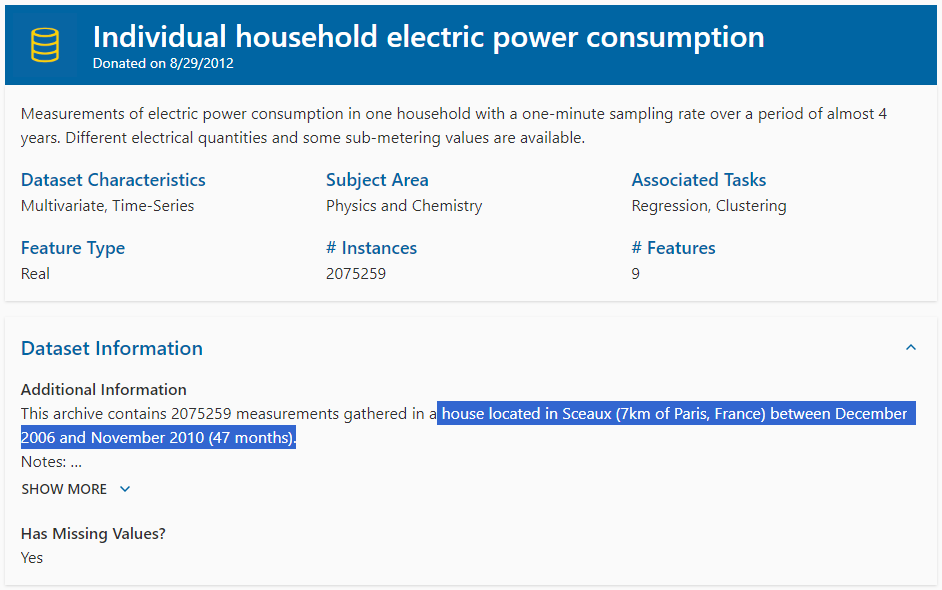

As we can see, this data was gathered from **Sceaux, next to Paris**. Based on this location 📍, we will use the **Weather API to fetch more data about this place**. It's sure to boost the model performance 🚀, since it's known that energy consumption is correlated to the weather 🌤, daylight ☀️, humidity 💧, and precipitation 🌧.

We will also add the **French holidays**, maybe the Total Energy Consumption is impacted by the holidays. 

## Read the French Holidays CSV File

I acquired this dataset from the website [Data.gouv.fr](https://www.data.gouv.fr/fr/datasets/jours-feries-en-france/).

In [11]:
french_holidays_df = pd.read_csv("./data/holidays/jours_feries_metropole.csv",
                         parse_dates=['date'])
french_holidays_df.head(3)

date  annee       zone   nom_jour_ferie
0 2004-01-01   2004  Métropole      1er janvier
1 2004-04-12   2004  Métropole  Lundi de Pâques
2 2004-05-01   2004  Métropole          1er mai

In [12]:
french_holidays = french_holidays_df.date
french_holidays

0     2004-01-01
1     2004-04-12
         ...    
284   2029-11-11
285   2029-12-25
Name: date, Length: 286, dtype: datetime64[ns]

We will use this data later to create a new column `is_holiday`, but for now let's focus on processing the Weather Data.

## Read the CSV Weather Files

I acquired this data from [Visual Crossing](https://www.visualcrossing.com/).

In [13]:
# Empty dictionary to store weather data
weather_dictionary = {}

# Directory containing the data files
data_directory = "./data/weather/"

for file_name in os.listdir(data_directory):
    if file_name.endswith(".csv"):
        weather_dictionary[file_name] = pd.read_csv(os.path.join(data_directory, file_name),
                                                     parse_dates=['datetime', 'sunrise', 'sunset'],
                                                     index_col='datetime')

# Display the file names in the weather dictionary
print(weather_dictionary.keys())

dict_keys(['Sceaux 2006-12-01 to 2009-07-31.csv', 'Sceaux 2009-08-01 to 2011-01-31.csv'])


### Concatenate and Prepare the Weather Data in a Pandas DataFrame
Since I used VisualCrossing to fetch the weather data for the Sceaux City during the energy consumption data collection, I will prepare and incorporate it into my RandomForestRegressor ML model to enhance its accuracy! 😁

In [14]:
# Concatenate all DataFrames in weather_dictionary along rows
weather_df = pd.concat([weather_df for df_name, weather_df in weather_dictionary.items()], axis=0)

weather_df.tail(2)

name  tempmax  tempmin  temp  feelslikemax  feelslikemin  \
datetime                                                                 
2011-01-30  Sceaux      1.5     -3.5  -1.4          -2.1          -8.5   
2011-01-31  Sceaux     -1.1     -4.2  -3.0          -3.2          -8.9   

            feelslike  dew  humidity  precip  precipprob  precipcover  \
datetime                                                                
2011-01-30       -5.6 -4.5      80.3     0.0           0          0.0   
2011-01-31       -6.7 -5.1      85.8     0.0           0          0.0   

           preciptype  snow  snowdepth  windgust  windspeed  winddir  \
datetime                                                               
2011-01-30        NaN   0.0        0.0      30.8       15.2     18.0   
2011-01-31        NaN   0.0        0.0      22.4       12.4      6.6   

            sealevelpressure  cloudcover  visibility  solarradiation  \
datetime                                                               
2011-01-30            1018.9        42.6         5.0            82.4   
2011-01-31            1024.9        70.7         3.0            79.2   

            solarenergy  uvindex  severerisk             sunrise  \
datetime                                                           
2011-01-30          7.1      4.0         NaN 2011-01-30 08:24:01   
2011-01-31          6.8      3.0         NaN 2011-01-31 08:22:43   

                        sunset  moonphase        conditions  \
datetime                                                      
2011-01-30 2011-01-30 17:44:45       0.87  Partially cloudy   
2011-01-31 2011-01-31 17:46:23       0.91  Partially cloudy   

                                  description               icon  \
datetime                                                           
2011-01-30         Clearing in the afternoon.  partly-cloudy-day   
2011-01-31  Partly cloudy throughout the day.  partly-cloudy-day   

                                                     stations  
datetime                                                       
2011-01-30  07149099999,07156099999,07146099999,0714509999...  
2011-01-31  07149099999,07156099999,07146099999,0714509999...

### Missing Values per Column for the Weather Dataset
We will first analyze this data in depth, select the possible features that could help make our **RandomForestRegressor** model better! 😁

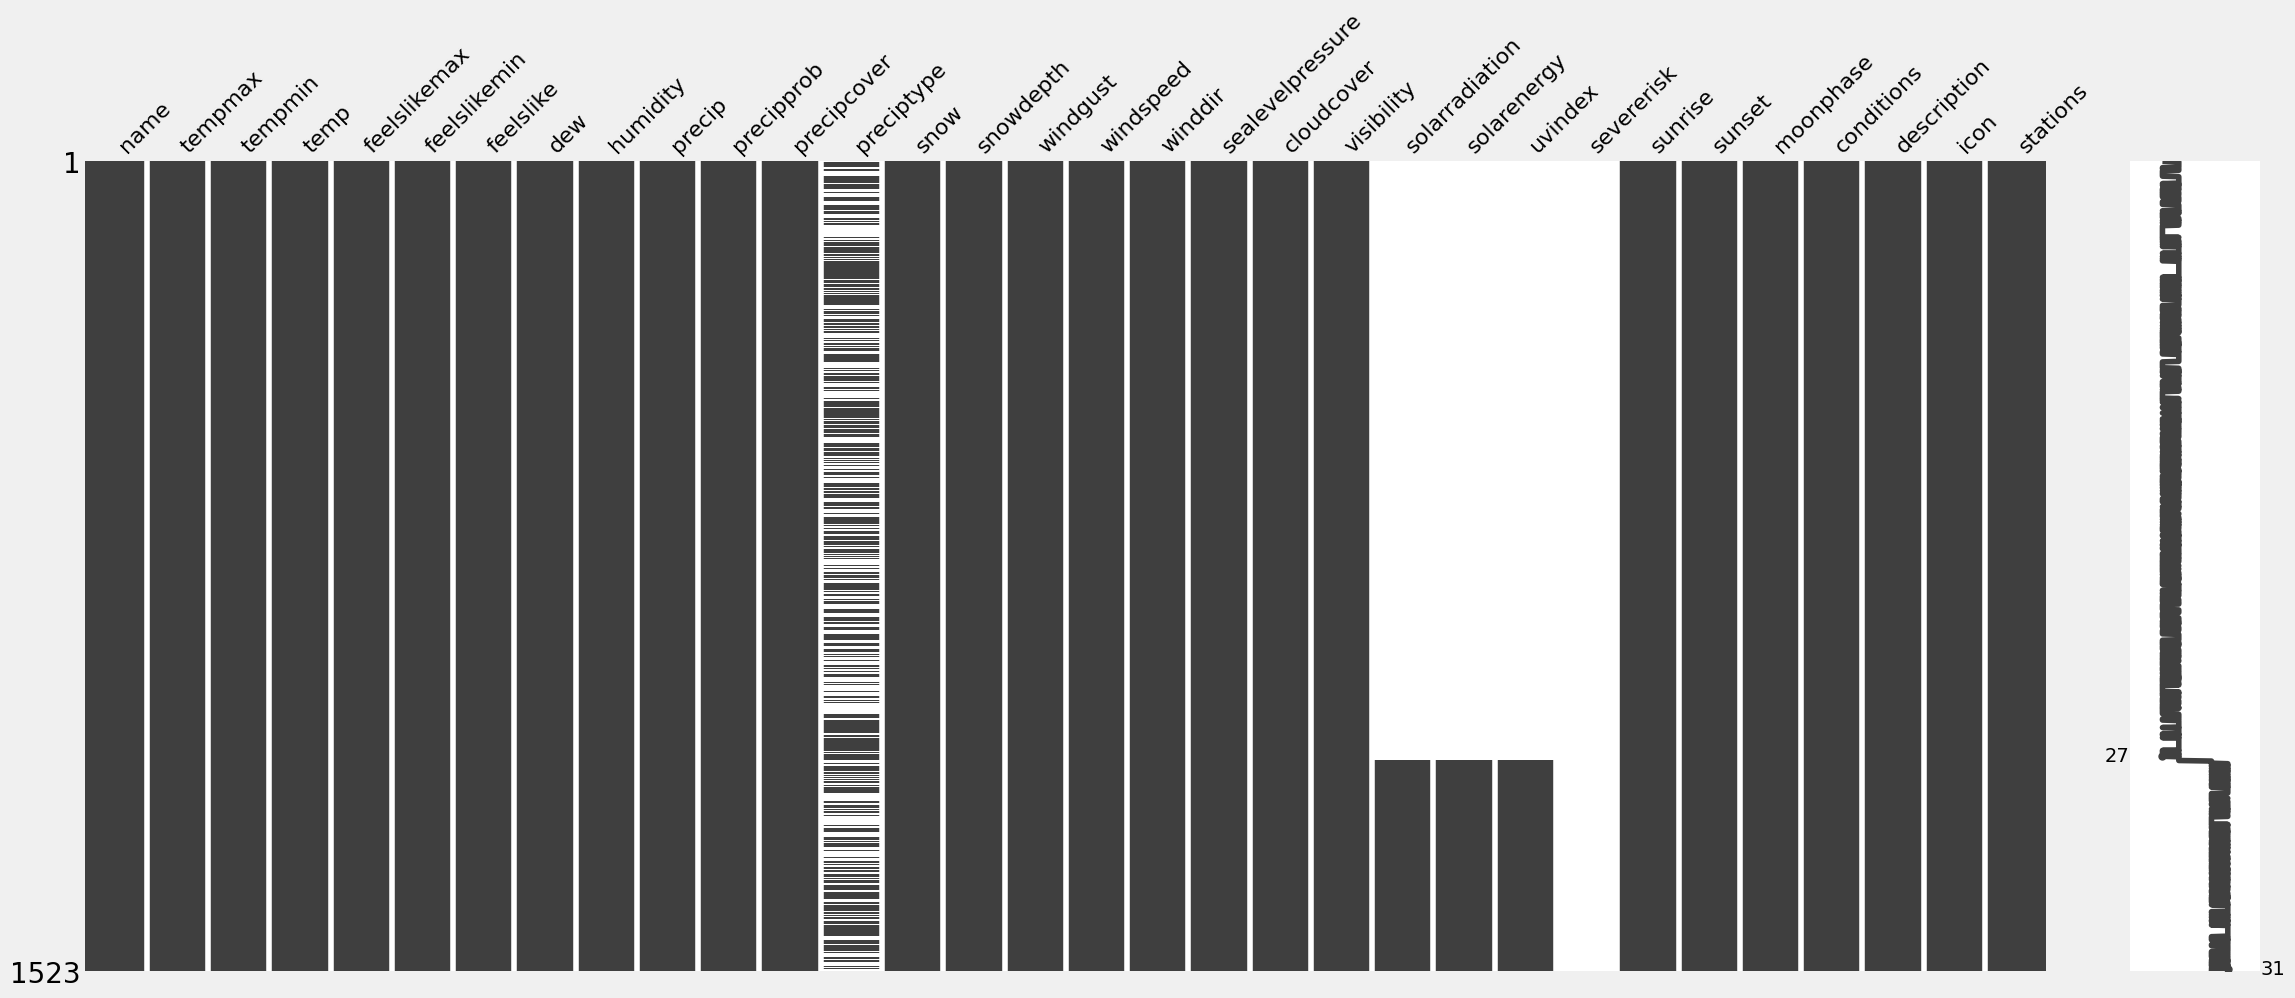

<Figure size 500x300 with 0 Axes>

In [15]:
# Generate the missing value matrix
msno.matrix(weather_df)

# Set the figure size to be smaller
plt.figure(figsize=(5, 3))

# Display the plot
plt.show()

### Data Preprocessing Steps

1. **Remove Missing Values:** Eliminate columns with missing data.
2. **Date Range Filtering:** Keep records between `2006-12-16` and `2010-11-26` (energy consumption interval).
3. **Encode 'Conditions':** Clean and apply One-Hot Encoding to the 'conditions' column, then drop it (OneHot encoding because the column isn't ordinal).
4. **Calculate Day Length:** Use 'Sunrise' and 'Sunset' to create a 'Day Length' feature, and remove the original columns (Daylight can impact energy consumption).

In [16]:
def clean_string(s):
    """
    Cleans a string: replaces spaces with underscores, removes special characters, and converts to lowercase.
    """
    return re.sub(r'[^a-zA-Z0-9\s]', '', s.replace(' ', '_')).lower()

def calculate_day_length(df, sunrise_col='sunrise', sunset_col='sunset'):
    """
    Adds 'day_length' to df calculated from 'sunrise' and 'sunset', and drops these columns.
    """
    df[sunrise_col] = pd.to_datetime(df[sunrise_col], format='%H:%M:%S').dt.time
    df[sunset_col] = pd.to_datetime(df[sunset_col], format='%H:%M:%S').dt.time
    df['day_length'] = ((pd.to_datetime(df[sunset_col].astype(str)) - pd.to_datetime(df[sunrise_col].astype(str))).dt.total_seconds()) / 3600.0
    return df.drop([sunrise_col, sunset_col], axis=1)

def preprocess_weather_data(df, start_date, end_date, columns_to_keep, column_to_encode):
    """
    Preprocesses weather data: sorts by index, filters by date, selects columns, encodes a column, and calculates day length.
    """
    # Ensure the DataFrame is sorted by its index
    df.sort_index(inplace=True)
    
    # Select specified columns
    df_selected = df[columns_to_keep].copy()
    
    # Filter by date range
    df_filtered = df_selected[(df_selected.index >= start_date) & (df_selected.index <= end_date)].copy()
    
    # Clean and encode specified column
    df_filtered[column_to_encode] = df_filtered[column_to_encode].apply(clean_string)
    dummies = pd.get_dummies(df_filtered[column_to_encode], prefix=column_to_encode)
    df_encoded = pd.concat([df_filtered, dummies], axis=1).drop(column_to_encode, axis=1)
    
    # Calculate day length and drop original sunrise and sunset columns
    return calculate_day_length(df_encoded)

In [17]:
# Columns to keep
columns_to_keep = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin', 'feelslike', 
                   'dew', 'humidity', 'precip', 'precipprob', 'precipcover', 'snow', 'snowdepth', 
                   'windgust', 'windspeed', 'winddir', 'sealevelpressure', 'cloudcover', 
                   'visibility', 'sunrise', 'sunset', 'moonphase', 'conditions']

# Start and End Weather Data Interval
start_date='2006-12-16'
end_date='2010-11-26'

# Columns to Encode using the One Hot Encoding 
column_to_encode='conditions'

# Proecess the Weather Dataframe
processed_weather_df = preprocess_weather_data(df=weather_df, 
                                               start_date=start_date, 
                                               end_date=end_date, 
                                               columns_to_keep=columns_to_keep, 
                                               column_to_encode=column_to_encode)

processed_weather_df.head(2)

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
datetime                                                                    
2006-12-16      8.2      3.4   5.7           5.7           0.6        2.9   
2006-12-17      7.2      0.6   3.4           5.9          -1.4        2.4   

            dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
datetime                                                                      
2006-12-16  4.1      89.8   1.853         100        29.17   0.0        0.0   
2006-12-17  2.3      92.4   0.314         100         8.33   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                 
2006-12-16      39.8       19.1    235.4            1023.2        68.6   
2006-12-17      17.2        9.2    227.6            1028.5        59.8   

            visibility  moonphase  conditions_clear  conditions_overcast  \
datetime                                                                   
2006-12-16        10.2       0.87             False                False   
2006-12-17         7.2       0.90             False                False   

            conditions_partiallycloudy  conditions_rain  \
datetime                                                  
2006-12-16                       False            False   
2006-12-17                       False            False   

            conditions_rainovercast  conditions_rainpartiallycloudy  \
datetime                                                              
2006-12-16                    False                            True   
2006-12-17                    False                            True   

            conditions_snowovercast  conditions_snowpartiallycloudy  \
datetime                                                              
2006-12-16                    False                           False   
2006-12-17                    False                           False   

            conditions_snowrain  conditions_snowrainovercast  \
datetime                                                       
2006-12-16                False                        False   
2006-12-17                False                        False   

            conditions_snowrainpartiallycloudy  day_length  
datetime                                                    
2006-12-16                               False    8.278889  
2006-12-17                               False    8.270833

### Importing the Consumption Data

In [18]:
# Data source
DATA_SOURCE_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip'
# Import data
consumptions = pd.read_csv(
    # Define the source
    DATA_SOURCE_URL,
    # Set separator
    sep =';',
    # Column names location
    header=0,
    # NA flag
    na_values='?',
    # Retain only a few columns
    usecols = ['Date','Time', 'Global_active_power'],
    # Type definition
    dtype={
        'Date':str,
        'Time':str,
        'Global_active_power':np.float64
    },
    # Date inference is not required
    infer_datetime_format=False
)

# Standardise column names using lower case
consumptions.rename(
    columns = {
        'Date':'date',
        'Time':'time',
        'Global_active_power':'total_consumption'
        },
    inplace=True
)
# Define the dataframe index based on the timestamp (date-time)
consumptions.index = pd.to_datetime(
    consumptions.date + "-" + consumptions.time,
    format = "%d/%m/%Y-%H:%M:%S"
)
# Drop the date and time variables that are now redondant with the index
consumptions.drop(columns=['date', 'time'], inplace=True)
# Color mapping for graphs
serie = ("total_consumption", "grey")

# We resample for you to continue the exercise
consumptions_df = consumptions.resample('D').sum()
consumptions_df.tail(2)

total_consumption
2010-11-25           1431.164
2010-11-26           1488.104

## Join the Dataframes by index

In [19]:
weather_and_consumption_df = pd.merge(processed_weather_df, consumptions_df, left_index=True, right_index=True)
weather_and_consumption_df

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
datetime                                                                    
2006-12-16      8.2      3.4   5.7           5.7           0.6        2.9   
2006-12-17      7.2      0.6   3.4           5.9          -1.4        2.4   
...             ...      ...   ...           ...           ...        ...   
2010-11-25      4.4      0.6   3.0           3.6          -3.0        0.9   
2010-11-26      2.8     -1.1   0.5           0.4          -5.8       -3.1   

            dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
datetime                                                                      
2006-12-16  4.1      89.8   1.853         100        29.17   0.0        0.0   
2006-12-17  2.3      92.4   0.314         100         8.33   0.0        0.0   
...         ...       ...     ...         ...          ...   ...        ...   
2010-11-25  0.8      85.8   0.987         100        25.00   0.0        0.0   
2010-11-26 -1.3      88.3   0.091         100        12.50   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                 
2006-12-16      39.8       19.1    235.4            1023.2        68.6   
2006-12-17      17.2        9.2    227.6            1028.5        59.8   
...              ...        ...      ...               ...         ...   
2010-11-25      33.4       13.6    309.4            1006.2        82.6   
2010-11-26      34.5       17.8    258.8            1007.7        66.7   

            visibility  moonphase  conditions_clear  conditions_overcast  \
datetime                                                                   
2006-12-16        10.2       0.87             False                False   
2006-12-17         7.2       0.90             False                False   
...                ...        ...               ...                  ...   
2010-11-25        14.9       0.63             False                False   
2010-11-26        13.1       0.67             False                False   

            conditions_partiallycloudy  conditions_rain  \
datetime                                                  
2006-12-16                       False            False   
2006-12-17                       False            False   
...                                ...              ...   
2010-11-25                       False            False   
2010-11-26                       False            False   

            conditions_rainovercast  conditions_rainpartiallycloudy  \
datetime                                                              
2006-12-16                    False                            True   
2006-12-17                    False                            True   
...                             ...                             ...   
2010-11-25                    False                           False   
2010-11-26                    False                           False   

            conditions_snowovercast  conditions_snowpartiallycloudy  \
datetime                                                              
2006-12-16                    False                           False   
2006-12-17                    False                           False   
...                             ...                             ...   
2010-11-25                    False                           False   
2010-11-26                    False                           False   

            conditions_snowrain  conditions_snowrainovercast  \
datetime                                                       
2006-12-16                False                        False   
2006-12-17                False                        False   
...                         ...                          ...   
2010-11-25                False                        False   
2010-11-26                False                        False   

       

## Add the French Holidays

In [20]:
# Convert the list of dates to a set for faster lookup
french_holidays_set = set(french_holidays)

# Add a new column 'is_holiday' to the DataFrame
weather_and_consumption_df['is_holiday'] = weather_and_consumption_df.index.isin(french_holidays_set)
weather_and_consumption_df.head(2)

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
datetime                                                                    
2006-12-16      8.2      3.4   5.7           5.7           0.6        2.9   
2006-12-17      7.2      0.6   3.4           5.9          -1.4        2.4   

            dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
datetime                                                                      
2006-12-16  4.1      89.8   1.853         100        29.17   0.0        0.0   
2006-12-17  2.3      92.4   0.314         100         8.33   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                 
2006-12-16      39.8       19.1    235.4            1023.2        68.6   
2006-12-17      17.2        9.2    227.6            1028.5        59.8   

            visibility  moonphase  conditions_clear  conditions_overcast  \
datetime                                                                   
2006-12-16        10.2       0.87             False                False   
2006-12-17         7.2       0.90             False                False   

            conditions_partiallycloudy  conditions_rain  \
datetime                                                  
2006-12-16                       False            False   
2006-12-17                       False            False   

            conditions_rainovercast  conditions_rainpartiallycloudy  \
datetime                                                              
2006-12-16                    False                            True   
2006-12-17                    False                            True   

            conditions_snowovercast  conditions_snowpartiallycloudy  \
datetime                                                              
2006-12-16                    False                           False   
2006-12-17                    False                           False   

            conditions_snowrain  conditions_snowrainovercast  \
datetime                                                       
2006-12-16                False                        False   
2006-12-17                False                        False   

            conditions_snowrainpartiallycloudy  day_length  total_consumption  \
datetime                                                                        
2006-12-16                               False    8.278889           1209.176   
2006-12-17                               False    8.270833           3390.460   

            is_holiday  
datetime                
2006-12-16       False  
2006-12-17       False

Let's check if May 1st, 2007 is labeled as a holiday or not 🤞

In [21]:
weather_and_consumption_df[weather_and_consumption_df.index=='2007-05-01'].is_holiday

datetime
2007-05-01    True
Name: is_holiday, dtype: bool



## Machine Learning

Now, we will create our Machine Learning flow to train the model to predict in the future. First, let's copy the prepared dataframe into a new dataframe.

In [22]:
df = weather_and_consumption_df.copy()



Let's create other possible features based on the target. The most important question now is: how far are we going to predict in the future? The further we predict, the harder it is for the model to make accurate predictions. Let's say we want to predict 7 days ahead.

### Feature Engineering

In [23]:
def create_features(df, column_names, lags, window_sizes):
    """
    Create time series features based on time series index and add lag and rolling features for specified columns.
    """
    # Create a copy of the DataFrame to avoid modifying the original data
    df = df.copy()

    # List to store created feature names
    created_features = []

    # Basic time series features
    basic_features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear']
    for feature in basic_features:
        # Add basic time series features to the DataFrame
        df[feature] = getattr(df.index, feature)
        created_features.append(feature)
    
    for column_name in column_names:
        # Lag features for each specified column
        for lag in lags:
            lag_feature_name = f'{column_name}_lag_{lag}'
            df[lag_feature_name] = df[column_name].shift(lag)
            created_features.append(lag_feature_name)
        
        # Rolling window features for each specified column
        for window in window_sizes:
            rolling_mean_name = f'{column_name}_rolling_mean_{window}'
            df[rolling_mean_name] = df[column_name].shift(1).rolling(window=window).mean()
            created_features.append(rolling_mean_name)
        
    return df, created_features

## Train / Test Split

### Define The Features and the Target

In [24]:
# Apply the Feature Engineering Function 
df, created_features = create_features(df, 
                                     column_names=['total_consumption', 'temp'], 
                                     lags=[1, 2, 3, 4, 5, 6, 7, 30, 90, 365], 
                                     window_sizes=[2, 3, 4, 5, 6, 7, 30, 90, 365])

# External Features that we managed to add
EXTERNAL_FEATURES = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
                     'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
                     'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
                     'sealevelpressure', 'cloudcover', 'visibility', 'moonphase',
                     'conditions_clear', 'conditions_overcast', 'conditions_partiallycloudy',
                     'conditions_rain', 'conditions_rainovercast',
                     'conditions_rainpartiallycloudy', 'conditions_snowovercast',
                     'conditions_snowpartiallycloudy', 'conditions_snowrain',
                     'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy',
                     'day_length', 'is_holiday']

# Features got with feature engineering
FEATURES = created_features

# Target Column
TARGET = 'total_consumption'

In [25]:
df.tail(3)

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
datetime                                                                    
2010-11-24      7.5      3.0   4.9           5.8          -0.6        2.5   
2010-11-25      4.4      0.6   3.0           3.6          -3.0        0.9   
2010-11-26      2.8     -1.1   0.5           0.4          -5.8       -3.1   

            dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
datetime                                                                      
2010-11-24  2.1      82.8   1.105         100        16.67   0.0        0.0   
2010-11-25  0.8      85.8   0.987         100        25.00   0.0        0.0   
2010-11-26 -1.3      88.3   0.091         100        12.50   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                 
2010-11-24      28.5       15.7    272.5            1011.0        80.0   
2010-11-25      33.4       13.6    309.4            1006.2        82.6   
2010-11-26      34.5       17.8    258.8            1007.7        66.7   

            visibility  moonphase  conditions_clear  conditions_overcast  \
datetime                                                                   
2010-11-24        19.7       0.60             False                False   
2010-11-25        14.9       0.63             False                False   
2010-11-26        13.1       0.67             False                False   

            conditions_partiallycloudy  conditions_rain  \
datetime                                                  
2010-11-24                       False            False   
2010-11-25                       False            False   
2010-11-26                       False            False   

            conditions_rainovercast  conditions_rainpartiallycloudy  \
datetime                                                              
2010-11-24                    False                            True   
2010-11-25                    False                           False   
2010-11-26                    False                           False   

            conditions_snowovercast  conditions_snowpartiallycloudy  \
datetime                                                              
2010-11-24                    False                           False   
2010-11-25                    False                           False   
2010-11-26                    False                           False   

            conditions_snowrain  conditions_snowrainovercast  \
datetime                                                       
2010-11-24                False                        False   
2010-11-25                False                        False   
2010-11-26                False                        False   

            conditions_snowrainpartiallycloudy  day_length  total_consumption  \
datetime                                                                        
2010-11-24                               False    8.815000           1796.248   
2010-11-25                                True    8.777500           1431.164   
2010-11-26                                True    8.741111           1488.104   

            is_holiday  dayofweek  quarter  month  year  dayofyear  \
datetime                                                             
2010-11-24       False          2        4     11  2010        328   
2010-11-25       False          3        4     11  2010        329   
2010-11-26       False          4        4     11  2010        330   

            total_consumption_lag_1  total_consumption_lag_2  \
datetime                                                       
2010-11-24                 1577.536                 2041.536   
2010-11-25                 1796.248                 1577.536   
2010-11-26                 1431.164                 1796.248   

            total_consumption_lag_3  total_consumption_lag_4  \
datetim

In [26]:
# Define a Threshold
threshold = '2010-05-17'

# Splitting the data into train and test sets based on the defined Threshold
train_df = df.loc[df.index < threshold].copy()
test_df = df.loc[df.index >= threshold].copy()

Let's first train the model on historical data and evaluate its performance in the future. We can split the data as follows:
- Training data consists of records where the date is before `2010-05-17`.
- Testing data consists of records where the date is on or after `2010-05-17`

In [27]:
X_train = train_df[FEATURES+EXTERNAL_FEATURES]
y_train = train_df[TARGET]

X_test = test_df[FEATURES+EXTERNAL_FEATURES]
y_test = test_df[TARGET]

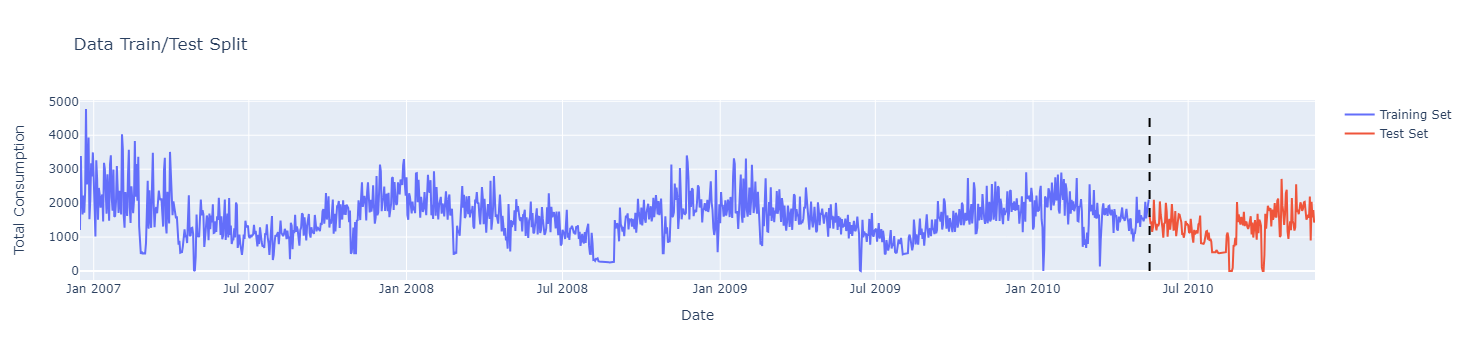

In [28]:
# Creating Plotly graph objects for training and test sets
trace1 = go.Scatter(x=train_df.index, y=train_df.total_consumption, mode='lines', name='Training Set')
trace2 = go.Scatter(x=test_df.index, y=test_df.total_consumption, mode='lines', name='Test Set')

# Adding a vertical line for the train-test split date based 
vline = go.layout.Shape(type="line", x0=threshold, y0=0, x1=threshold, y1=max(df.total_consumption),
                        line=dict(color="Black", width=2, dash="dash"))

layout = go.Layout(title='Data Train/Test Split',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Total Consumption'),
                   shapes=[vline])

fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

## Training Models for Predicting Next-Day Values

In our initial scenario, we aim to train a model capable of forecasting values one day ahead. This task, leveraging a 1-day lag, presents a straightforward challenge. We anticipate the 1-day lag feature to emerge as significantly important post-training. To assess performance, we will develop and train two types of models: a Simple Random Forest and an XGBoost regressor.s.

In [29]:
X_train.columns

Index(['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'total_consumption_lag_1', 'total_consumption_lag_2',
       'total_consumption_lag_3', 'total_consumption_lag_4',
       'total_consumption_lag_5', 'total_consumption_lag_6',
       'total_consumption_lag_7', 'total_consumption_lag_30',
       'total_consumption_lag_90', 'total_consumption_lag_365',
       'total_consumption_rolling_mean_2', 'total_consumption_rolling_mean_3',
       'total_consumption_rolling_mean_4', 'total_consumption_rolling_mean_5',
       'total_consumption_rolling_mean_6', 'total_consumption_rolling_mean_7',
       'total_consumption_rolling_mean_30',
       'total_consumption_rolling_mean_90',
       'total_consumption_rolling_mean_365', 'temp_lag_1', 'temp_lag_2',
       'temp_lag_3', 'temp_lag_4', 'temp_lag_5', 'temp_lag_6', 'temp_lag_7',
       'temp_lag_30', 'temp_lag_90', 'temp_lag_365', 'temp_rolling_mean_2',
       'temp_rolling_mean_3', 'temp_rolling_mean_4', 'temp_rolling_mean_5',
   

In [30]:
# Instantiate and train Random Forest Regressor
rfr = RandomForestRegressor(n_estimators=600, max_depth=3)

# Instantiate and train XGBoost Regressor
import xgboost as xgb
xgb = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

In [31]:
# Train the Random Forest Regressor model
rfr.fit(X_train, y_train)

# Train the XGBoost Regressor
xgb.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_train, y_train)], 
        verbose=100)

[0]	validation_0-rmse:1692.38493	validation_1-rmse:1692.38493
[100]	validation_0-rmse:732.79627	validation_1-rmse:732.79627
[200]	validation_0-rmse:447.17161	validation_1-rmse:447.17161
[300]	validation_0-rmse:372.07137	validation_1-rmse:372.07137
[400]	validation_0-rmse:347.50982	validation_1-rmse:347.50982
[500]	validation_0-rmse:334.46524	validation_1-rmse:334.46524
[600]	validation_0-rmse:325.05613	validation_1-rmse:325.05613
[700]	validation_0-rmse:315.80875	validation_1-rmse:315.80875
[800]	validation_0-rmse:307.31847	validation_1-rmse:307.31847
[900]	validation_0-rmse:299.41370	validation_1-rmse:299.41370
[999]	validation_0-rmse:291.26357	validation_1-rmse:291.26357


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

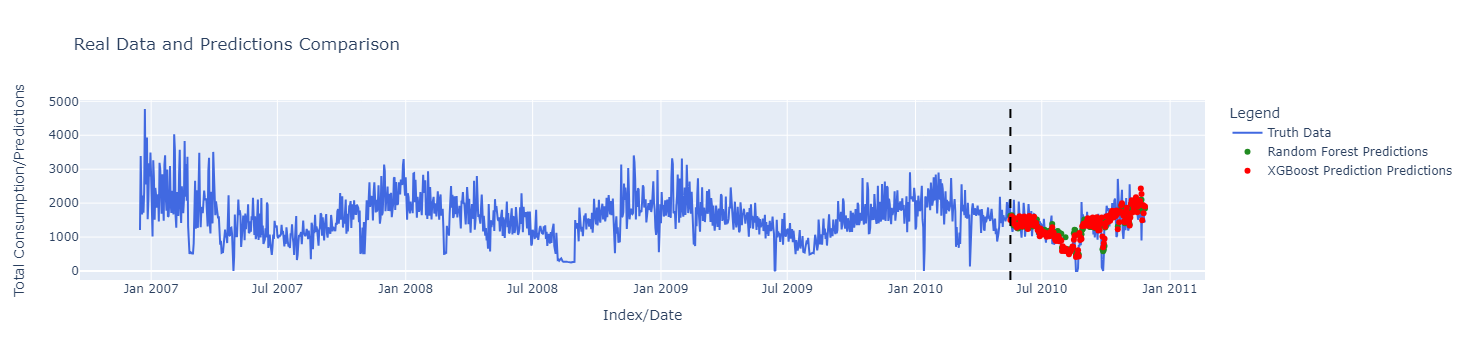

Random Forest RMSE: 367.36977904847237
XGBoost RMSE: 363.33691473196706


In [32]:
# Adding Random Forest predictions to the test set DataFrame
test_df['RandomForest_Prediction'] = rfr.predict(X_test)
test_df['XGBoost_Prediction'] = xgb.predict(X_test)

df_final = df.merge(test_df[['RandomForest_Prediction', 'XGBoost_Prediction']], how='left', left_index=True, right_index=True)

# Plotly graph for truth data and predictions
truth_data = go.Scatter(x=df_final.index, y=df_final['total_consumption'], mode='lines', name='Truth Data', line=dict(color='RoyalBlue'))
random_forest_predictions = go.Scatter(x=df_final.index, y=df_final['RandomForest_Prediction'], mode='markers', name='Random Forest Predictions', marker=dict(color='ForestGreen'))
xgboost_predictions = go.Scatter(x=df_final.index, y=df_final['XGBoost_Prediction'], mode='markers', name='XGBoost Prediction Predictions', marker=dict(color='red'))

# Adding a vertical line for the train-test split date
vline = dict(
    type="line", x0=threshold, y0=0, x1=threshold, y1=1, line=dict(color="Black", width=2, dash="dash"), xref='x', yref='paper'
)
# Update layout for a better visual presentation
layout = go.Layout(
    title='Real Data and Predictions Comparison',
    xaxis=dict(title='Index/Date'),
    yaxis=dict(title='Total Consumption/Predictions'),
    legend_title='Legend',
    shapes=[vline]  # Adding the vertical line to the layout
)

fig = go.Figure(data=[truth_data, random_forest_predictions, xgboost_predictions], layout=layout)

# Show the interactive plot
fig.show()

# Calculate the RMSE for the Random Forest Model on the Test Data
y_pred_rfr = rfr.predict(X_test)
rmse_rfr = np.sqrt(mean_squared_error(y_test, y_pred_rfr))
print(f"Random Forest RMSE: {rmse_rfr}")

# Calculate the RMSE for the XGBoost Model on the Test Data
y_pred_xgb = xgb.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"XGBoost RMSE: {rmse_xgb}")

### Plot the Feature Importance

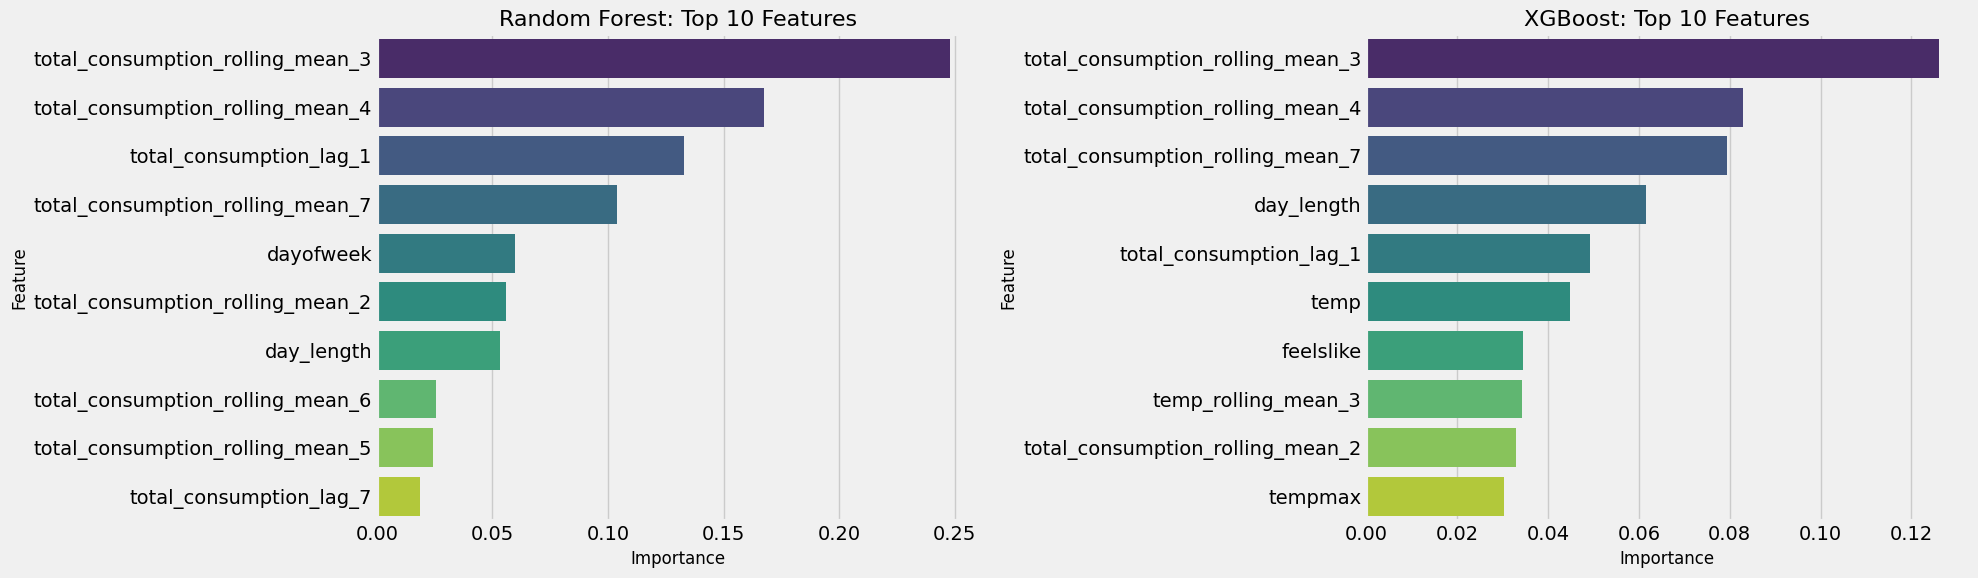

In [33]:
# Create DataFrame for feature importances
feature_data_rfr = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': rfr.feature_importances_,
    'Model': 'Random Forest'
})

feature_data_xgb = pd.DataFrame({
    'Feature': X_train.columns, 
    'Importance': xgb.feature_importances_,
    'Model': 'XGBoost'
})

# Combine the DataFrames
feature_data_combined = pd.concat([feature_data_rfr, feature_data_xgb])

# Sort each DataFrame by importance and select the top 10 features
top_features_rfr = feature_data_rfr.sort_values(by='Importance', ascending=False).head(10)
top_features_xgb = feature_data_xgb.sort_values(by='Importance', ascending=False).head(10)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 line, 2 plots

# Random Forest
sns.barplot(data=top_features_rfr, x='Importance', y='Feature', palette='viridis', ax=axs[0])
axs[0].set_title('Random Forest: Top 10 Features', fontsize=16)
axs[0].set_xlabel('Importance', fontsize=12)
axs[0].set_ylabel('Feature', fontsize=12)

# XGBoost
sns.barplot(data=top_features_xgb, x='Importance', y='Feature', palette='viridis', ax=axs[1])
axs[1].set_title('XGBoost: Top 10 Features', fontsize=16)
axs[1].set_xlabel('Importance', fontsize=12)
axs[1].set_ylabel('Feature', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

## Training Models for 30-Day Future Predictions

In our second scenario, we focus on developing a model to forecast values 30 days into the future. This presents a significantly more challenging task. To enhance the model's performance, we will employ Time Series Cross-Validation. This approach involves repeatedly training the model on the dataset using a sliding window technique, aiming for predictions spanning 30 days. For clarity and insight, these predictions will be visualized through plotting. We plan to build and train two types of models: a Simple Random Forest and an XGBoost regressor. Additionally, we will visualize the feature importance to identify which factors most influence the model's predictions.

### Time Series Cross Validation

In [34]:
# Copy the Original Dataset
df = weather_and_consumption_df.copy()

# Apply the Feature Engineering Function 
df, created_features = create_features(df, 
                         column_names=['total_consumption', 'temp'], 
                         lags=[30, 60, 90, 365], 
                         window_sizes=[30, 60, 90, 365])

# Features got with feature engineering
FEATURES = created_features

# External Features that we managed to add
EXTERNAL_FEATURES = ['tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
                     'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
                     'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
                     'sealevelpressure', 'cloudcover', 'visibility', 'moonphase',
                     'conditions_clear', 'conditions_overcast', 'conditions_partiallycloudy',
                     'conditions_rain', 'conditions_rainovercast',
                     'conditions_rainpartiallycloudy', 'conditions_snowovercast',
                     'conditions_snowpartiallycloudy', 'conditions_snowrain',
                     'conditions_snowrainovercast', 'conditions_snowrainpartiallycloudy',
                     'day_length', 'is_holiday']

# Target Column
TARGET = 'total_consumption'

In [35]:
# Define a Threshold
threshold = '2010-05-17'

# Splitting the data into train and test sets based on the defined Threshold
train_df_cv = df.loc[df.index < threshold].copy()
test_df_cv = df.loc[df.index >= threshold].copy()

In [36]:
X_train_cv = train_df_cv[FEATURES+EXTERNAL_FEATURES]
y_train_cv = train_df_cv[TARGET]

X_test_cv = test_df_cv[FEATURES+EXTERNAL_FEATURES]
y_test_cv = test_df_cv[TARGET]

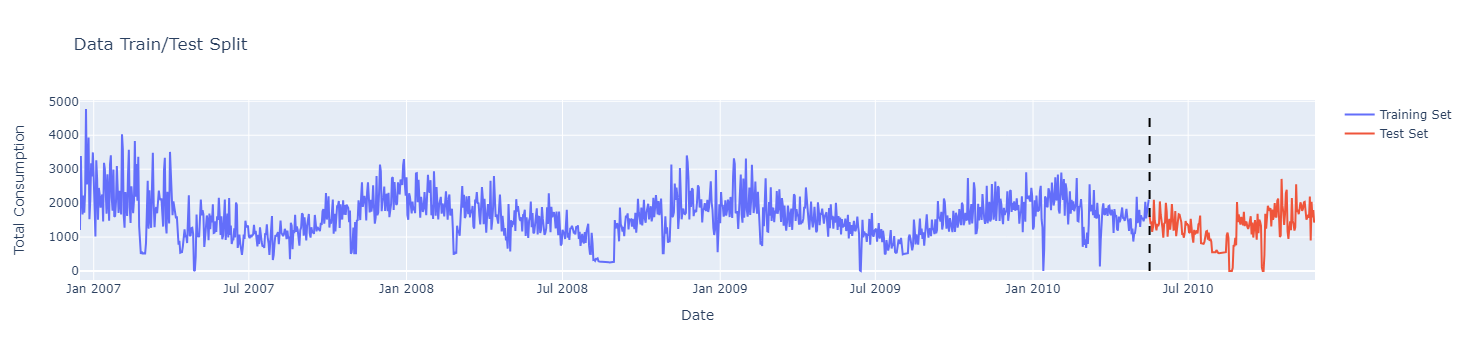

In [37]:
# Creating Plotly graph objects for training and test sets
trace1 = go.Scatter(x=train_df_cv.index, y=train_df_cv.total_consumption, mode='lines', name='Training Set')
trace2 = go.Scatter(x=test_df_cv.index, y=test_df_cv.total_consumption, mode='lines', name='Test Set')

# Adding a vertical line for the train-test split date
vline = go.layout.Shape(type="line", x0=threshold, y0=0, x1=threshold, y1=max(df.total_consumption),
                        line=dict(color="Black", width=2, dash="dash"))

layout = go.Layout(title='Data Train/Test Split',
                   xaxis=dict(title='Date'),
                   yaxis=dict(title='Total Consumption'),
                   shapes=[vline])

fig = go.Figure(data=[trace1, trace2], layout=layout)

# Show plot
fig.show()

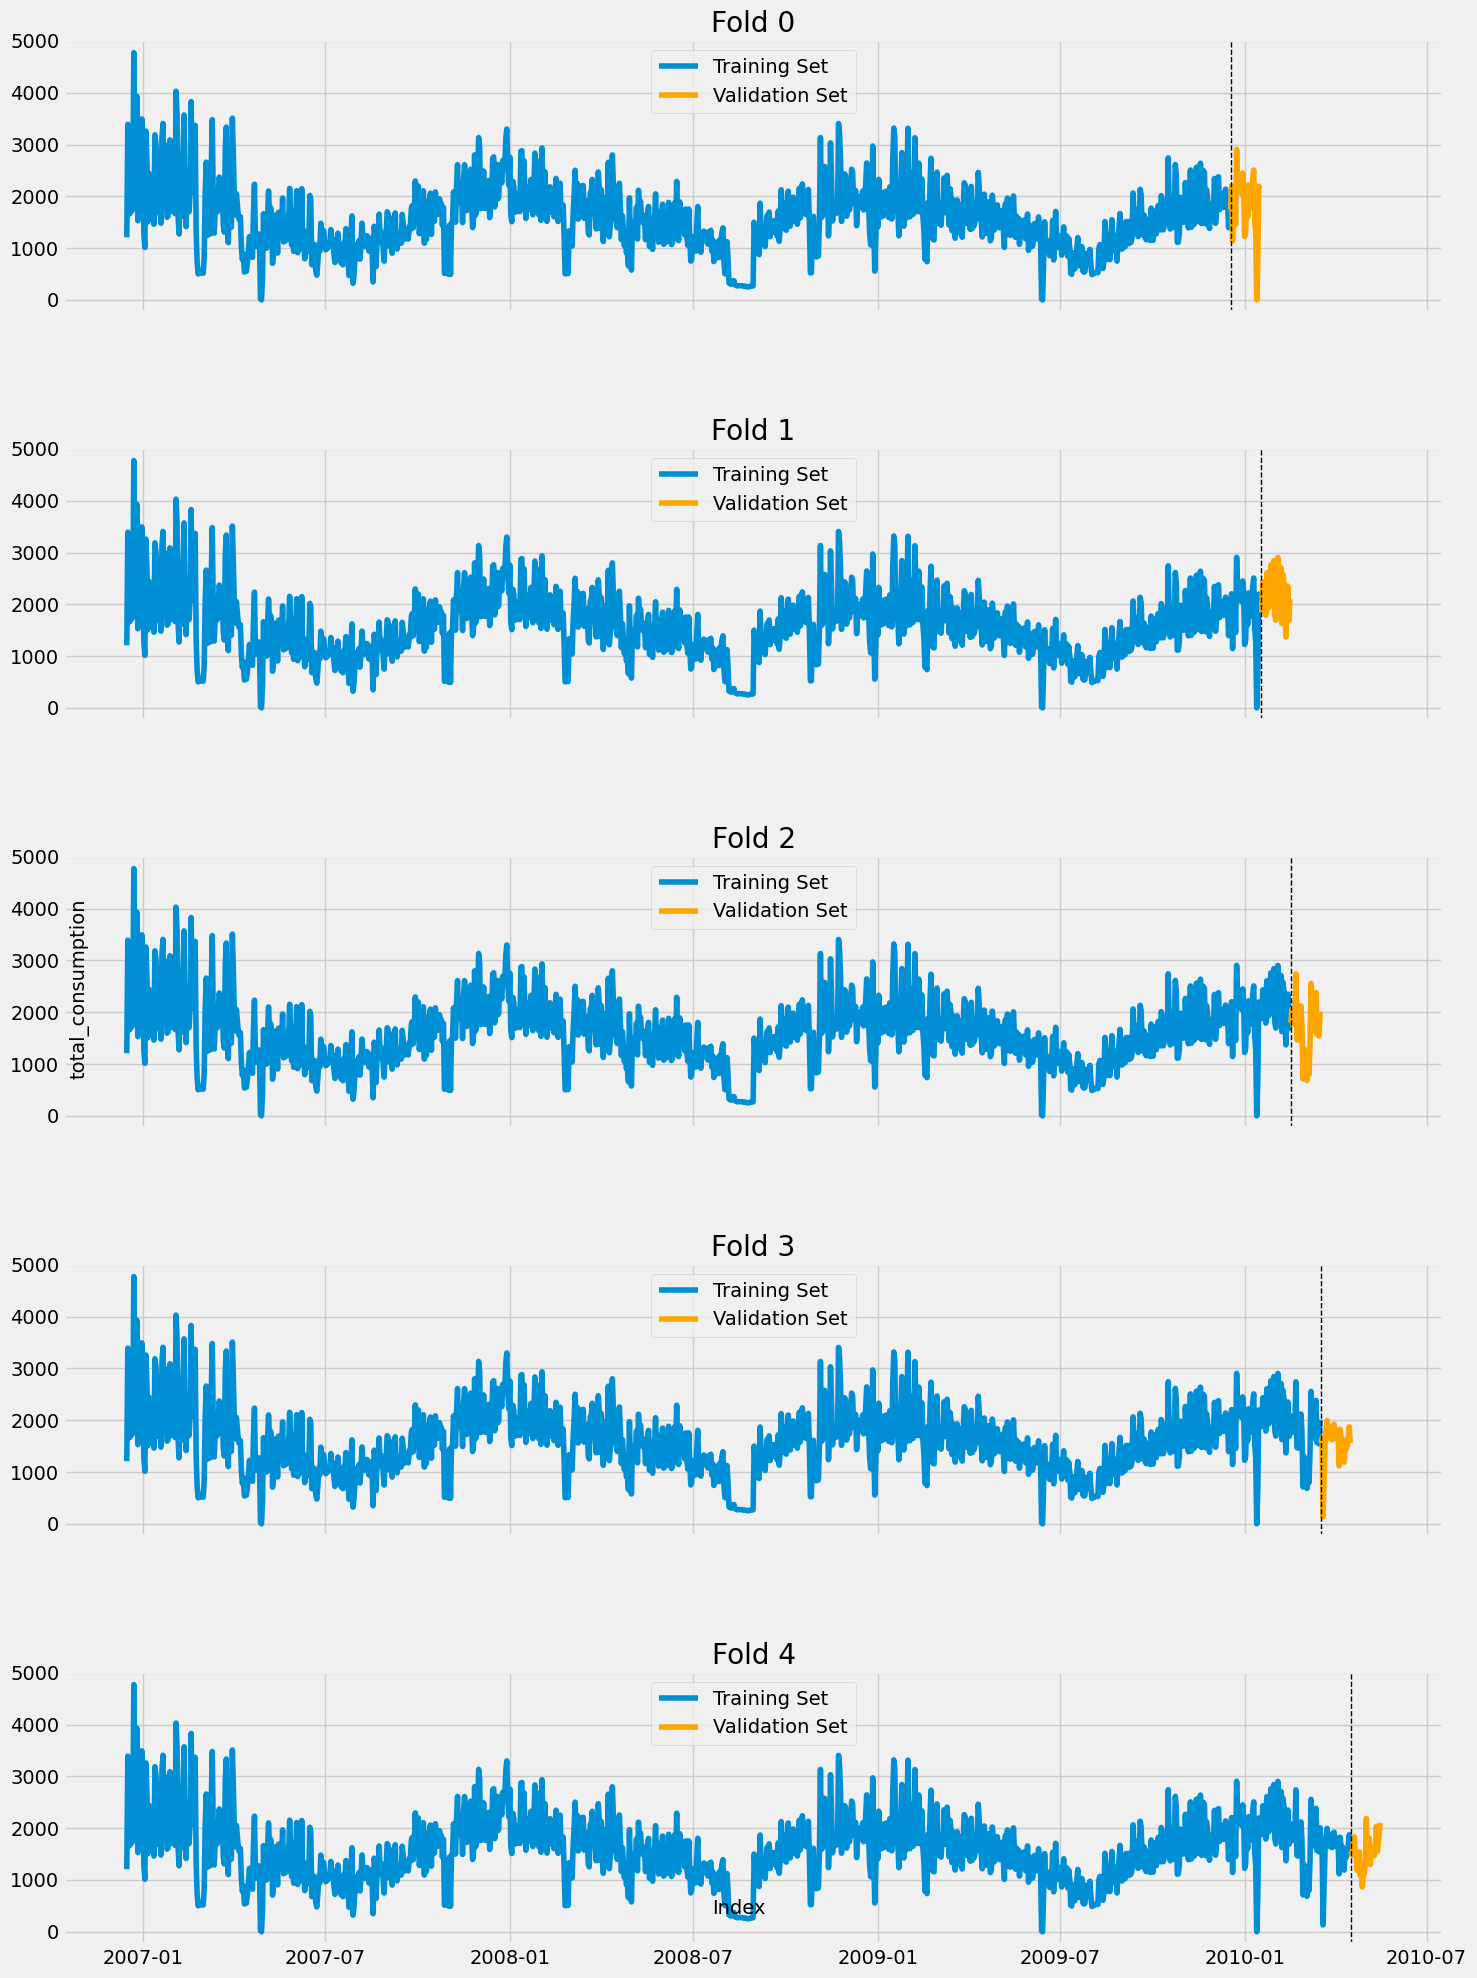

In [38]:
tss = TimeSeriesSplit(n_splits=5, test_size=30)

fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

for fold, (train_idx, val_idx) in enumerate(tss.split(train_df_cv)):
    train_cv = df.iloc[train_idx]
    test_cv = df.iloc[val_idx]
    
    # Plot Training Set
    axs[fold].plot(train_cv.index, train_cv[TARGET], label='Training Set')
    
    # Plot Test Set
    axs[fold].plot(test_cv.index, test_cv[TARGET], label='Validation Set', color='orange')
    
    # Mark the beginning of the test set
    axs[fold].axvline(test_cv.index.min(), color='black', ls='--', lw=1)
    
    # Set title for each subplot
    axs[fold].set_title(f'Fold {fold}')
    
    # Add legend to each subplot
    axs[fold].legend()

# Improve layout to prevent label overlap and set a shared xlabel
plt.tight_layout()
fig.subplots_adjust(hspace=0.5)  # Adjust space between plots
fig.text(0.5, 0.04, 'Index', ha='center', va='center')
fig.text(0.06, 0.5, TARGET, ha='center', va='center', rotation='vertical')

plt.show()

In [39]:
X_train_cv.columns

Index(['dayofweek', 'quarter', 'month', 'year', 'dayofyear',
       'total_consumption_lag_30', 'total_consumption_lag_60',
       'total_consumption_lag_90', 'total_consumption_lag_365',
       'total_consumption_rolling_mean_30',
       'total_consumption_rolling_mean_60',
       'total_consumption_rolling_mean_90',
       'total_consumption_rolling_mean_365', 'temp_lag_30', 'temp_lag_60',
       'temp_lag_90', 'temp_lag_365', 'temp_rolling_mean_30',
       'temp_rolling_mean_60', 'temp_rolling_mean_90', 'temp_rolling_mean_365',
       'tempmax', 'tempmin', 'temp', 'feelslikemax', 'feelslikemin',
       'feelslike', 'dew', 'humidity', 'precip', 'precipprob', 'precipcover',
       'snow', 'snowdepth', 'windgust', 'windspeed', 'winddir',
       'sealevelpressure', 'cloudcover', 'visibility', 'moonphase',
       'conditions_clear', 'conditions_overcast', 'conditions_partiallycloudy',
       'conditions_rain', 'conditions_rainovercast',
       'conditions_rainpartiallycloudy', 'condition

In [40]:
preds = []
scores = []

# Define the Random Forest Regressor
rfr_cv = RandomForestRegressor(n_estimators=600, max_depth=3)

# Define the XGBoost Regressor
import xgboost as xgb
xgb_cv = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                          n_estimators=1000,
                          early_stopping_rounds=50,
                          objective='reg:squarederror',
                          max_depth=3,
                          learning_rate=0.01)

for fold, (train_idx, val_idx) in tqdm(enumerate(tss.split(X_train_cv))):
    X_train_fold = X_train_cv.iloc[train_idx]
    y_train_fold = y_train_cv.iloc[train_idx]
    X_val_fold = X_train_cv.iloc[val_idx]
    y_val_fold = y_train_cv.iloc[val_idx]

    # Fit the Random Forest model
    rfr_cv.fit(X_train_fold, y_train_fold)
    # Predict on the validation set
    y_pred_rfr = rfr_cv.predict(X_val_fold)
    # Calculate and store the score for Random Forest
    score_rfr = np.sqrt(mean_squared_error(y_val_fold, y_pred_rfr))
    print(f"Fold {fold}: Random Forest Regressor RMSE = {score_rfr}")
    
    # Fit the XGBoost model with early stopping
    xgb_cv.fit(X_train_fold, y_train_fold,
               eval_set=[(X_val_fold, y_val_fold)],
               verbose=100)
    # Predict on the validation set using the best iteration
    y_pred_xgb = xgb_cv.predict(X_val_fold)
    # Calculate and store the score for XGBoost
    score_xgb = np.sqrt(mean_squared_error(y_val_fold, y_pred_xgb))
    print(f"Fold {fold}: XGBoost Regressor RMSE = {score_xgb}")
    
    # Storing predictions and scores
    preds.append({'RF': y_pred_rfr, 'XGB': y_pred_xgb})
    scores.append({'RF': score_rfr, 'XGB': score_xgb})

# Optionally, calculate and print the average score across all folds for each model
avg_score_rfr = np.mean([score['RF'] for score in scores])
avg_score_xgb = np.mean([score['XGB'] for score in scores])
print(f"Random Forest Regressor Average RMSE across all folds: {avg_score_rfr}")
print(f"XGBoost Regressor Average RMSE across all folds: {avg_score_xgb}")

0it [00:00, ?it/s]

Fold 0: Random Forest Regressor RMSE = 597.6813242385114
[0]	validation_0-rmse:1905.01858
[100]	validation_0-rmse:803.55199
[200]	validation_0-rmse:594.52587
[300]	validation_0-rmse:586.02355
[322]	validation_0-rmse:589.73277


1it [00:11, 11.50s/it]

Fold 0: XGBoost Regressor RMSE = 579.7082569340822
Fold 1: Random Forest Regressor RMSE = 461.8833987211732
[0]	validation_0-rmse:2173.90116
[100]	validation_0-rmse:1015.67966
[200]	validation_0-rmse:625.90813
[300]	validation_0-rmse:514.30022
[400]	validation_0-rmse:495.66138
[500]	validation_0-rmse:481.00770
[600]	validation_0-rmse:476.06478
[700]	validation_0-rmse:472.84855
[742]	validation_0-rmse:473.07431


2it [00:24, 12.64s/it]

Fold 1: XGBoost Regressor RMSE = 472.47051304262834
Fold 2: Random Forest Regressor RMSE = 536.0098097010577
[0]	validation_0-rmse:1715.46247
[100]	validation_0-rmse:734.56895
[200]	validation_0-rmse:530.16320
[284]	validation_0-rmse:529.88260


3it [00:34, 11.39s/it]

Fold 2: XGBoost Regressor RMSE = 526.4681043775337
Fold 3: Random Forest Regressor RMSE = 402.2512107941197
[0]	validation_0-rmse:1598.53009
[100]	validation_0-rmse:642.25632
[200]	validation_0-rmse:422.02352
[295]	validation_0-rmse:420.17326


4it [00:44, 10.81s/it]

Fold 3: XGBoost Regressor RMSE = 410.82557993326833
Fold 4: Random Forest Regressor RMSE = 257.39295147038445
[0]	validation_0-rmse:1546.48948
[100]	validation_0-rmse:611.47161
[200]	validation_0-rmse:334.52400
[300]	validation_0-rmse:275.03390
[400]	validation_0-rmse:264.11654
[500]	validation_0-rmse:259.93849
[600]	validation_0-rmse:257.87256
[700]	validation_0-rmse:257.07797
[800]	validation_0-rmse:256.39282
[838]	validation_0-rmse:256.87457


5it [00:57, 11.44s/it]

Fold 4: XGBoost Regressor RMSE = 256.2019938980512
Random Forest Regressor Average RMSE across all folds: 451.0437389850493
XGBoost Regressor Average RMSE across all folds: 449.1348896371127


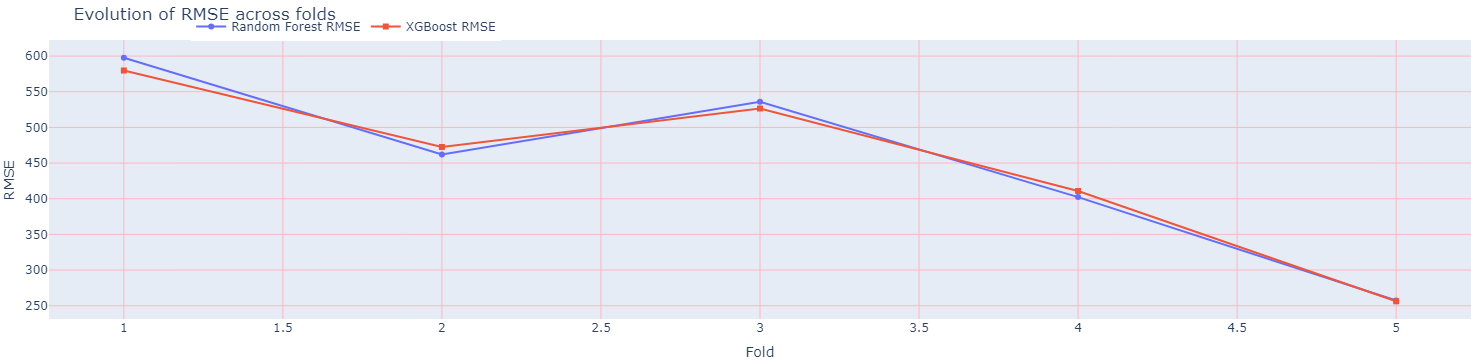

In [50]:
# Extract RMSE scores for each model
rf_rmse_scores = [score['RF'] for score in scores]
xgb_rmse_scores = [score['XGB'] for score in scores]
folds = list(range(1, len(rf_rmse_scores) + 1))

# Create traces
trace_rf = go.Scatter(x=folds, y=rf_rmse_scores, mode='lines+markers', name='Random Forest RMSE', marker=dict(symbol='circle'))
trace_xgb = go.Scatter(x=folds, y=xgb_rmse_scores, mode='lines+markers', name='XGBoost RMSE', marker=dict(symbol='square'))

# Layout
layout = go.Layout(
    title='Evolution of RMSE across folds',
    xaxis=dict(title='Fold'),
    yaxis=dict(title='RMSE'),
    margin=dict(l=0, r=0, t=40, b=40),
    legend=dict(x=0.1, y=1.1, orientation='h')
)

# Figure
fig = go.Figure(data=[trace_rf, trace_xgb], layout=layout)

# Add grid
fig.update_xaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')
fig.update_yaxes(showgrid=True, gridwidth=1, gridcolor='LightPink')

# Show plot
fig.show()

### Testing the perfomance after the Cross Validation

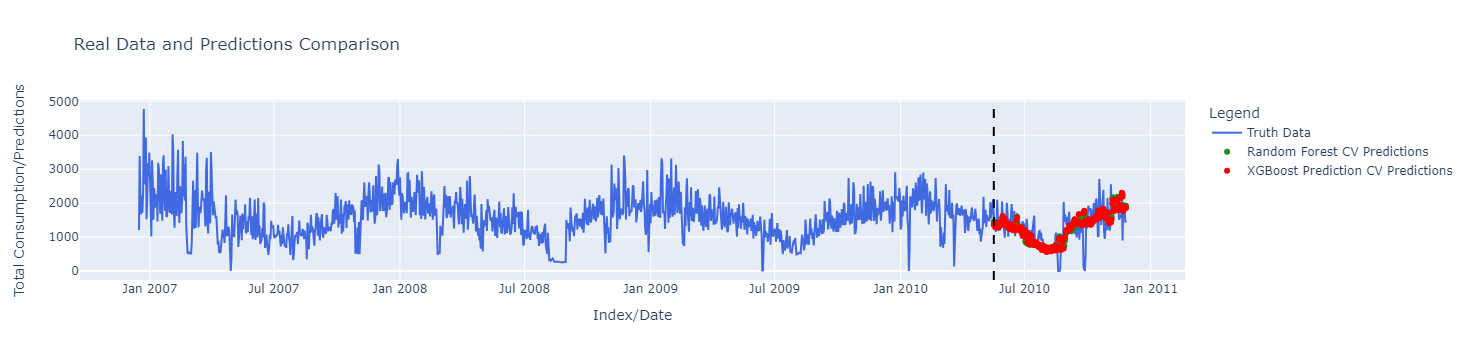

Random Forest RMSE: 432.8759604867637
XGBoost RMSE: 422.27414559247444


In [42]:
# Adding Random Forest predictions to the test set DataFrame
test_df_cv['RandomForest_Prediction_cv'] = rfr_cv.predict(X_test_cv)
test_df_cv['XGBoost_Prediction_cv'] = xgb_cv.predict(X_test_cv)


df_final = df.merge(test_df_cv[['RandomForest_Prediction_cv', 'XGBoost_Prediction_cv']], how='left', left_index=True, right_index=True)

# Plotly graph for truth data and predictions
truth_data = go.Scatter(x=df_final.index, y=df_final['total_consumption'], mode='lines', name='Truth Data', line=dict(color='RoyalBlue'))
random_forest_predictions = go.Scatter(x=df_final.index, y=df_final['RandomForest_Prediction_cv'], mode='markers', name='Random Forest CV Predictions', marker=dict(color='ForestGreen'))
xgboost_predictions = go.Scatter(x=df_final.index, y=df_final['XGBoost_Prediction_cv'], mode='markers', name='XGBoost Prediction CV Predictions', marker=dict(color='red'))

# Adding a vertical line for the train-test split date
vline = dict(
    type="line", x0=threshold, y0=0, x1=threshold, y1=1, line=dict(color="Black", width=2, dash="dash"), xref='x', yref='paper'
)

# Update layout for a better visual presentation
layout = go.Layout(
    title='Real Data and Predictions Comparison',
    xaxis=dict(title='Index/Date'),
    yaxis=dict(title='Total Consumption/Predictions'),
    legend_title='Legend',
    shapes=[vline]  # Adding the vertical line to the layout
)

fig = go.Figure(data=[truth_data, random_forest_predictions, xgboost_predictions], layout=layout)

# Show the interactive plot
fig.show()

# Calculate the RMSE for the Random Forest Model on the Test Data
y_pred_rfr_cv = rfr_cv.predict(X_test_cv)
rmse_rfr_cv = np.sqrt(mean_squared_error(y_test_cv, y_pred_rfr_cv))
print(f"Random Forest RMSE: {rmse_rfr_cv}")

# Calculate the RMSE for the XGBoost Model on the Test Data
y_pred_xgb_cv = xgb_cv.predict(X_test_cv)
rmse_xgb_cv = np.sqrt(mean_squared_error(y_test_cv, y_pred_xgb_cv))
print(f"XGBoost RMSE: {rmse_xgb_cv}")

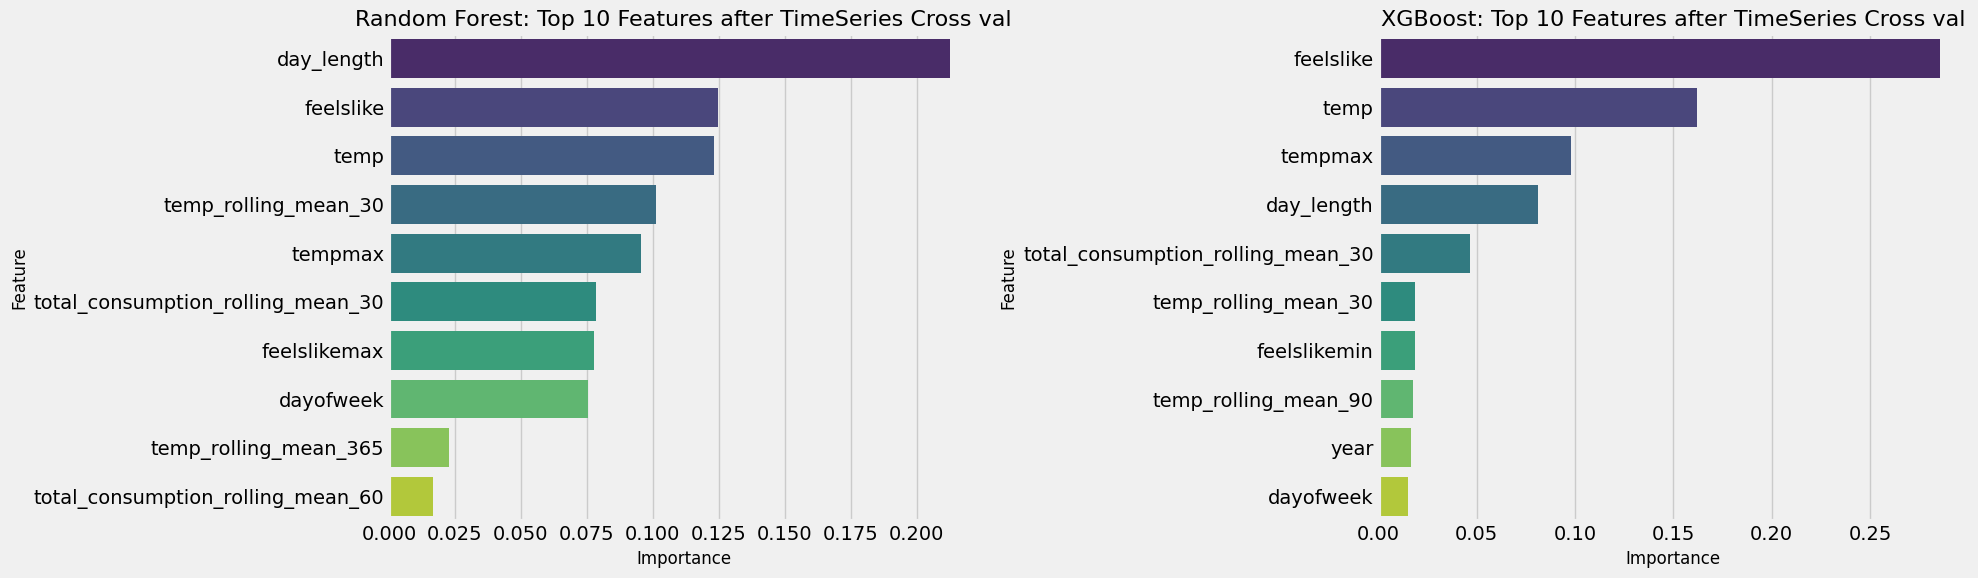

In [43]:
# Create DataFrame for Random Forest feature importances
feature_data_rfr = pd.DataFrame({
    'Feature': X_train_cv.columns, 
    'Importance': rfr_cv.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# Create DataFrame for XGBoost feature importances
feature_data_xgb = pd.DataFrame({
    'Feature': X_train_cv.columns, 
    'Importance': xgb_cv.feature_importances_
}).sort_values(by='Importance', ascending=False).head(10)

# Plotting
fig, axs = plt.subplots(1, 2, figsize=(20, 6))  # 1 line, 2 plots

# Random Forest
sns.barplot(data=feature_data_rfr, x='Importance', y='Feature', palette='viridis', ax=axs[0])
axs[0].set_title('Random Forest: Top 10 Features after TimeSeries Cross val', fontsize=16)
axs[0].set_xlabel('Importance', fontsize=12)
axs[0].set_ylabel('Feature', fontsize=12)

# XGBoost
sns.barplot(data=feature_data_xgb, x='Importance', y='Feature', palette='viridis', ax=axs[1])
axs[1].set_title('XGBoost: Top 10 Features after TimeSeries Cross val', fontsize=16)
axs[1].set_xlabel('Importance', fontsize=12)
axs[1].set_ylabel('Feature', fontsize=12)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()

---
## 🚀 **Turn it into an App!**

It's time to prioritize the end user's experience and deliver a seamless interface for them to utilize the model. Users will input a dataframe, typically a CSV file containing historical data, and receive an estimation of the total consumption for the following day!

For preprocessing, we'll utilize the Feature Importance Graph to identify the most significant features. Users can also specify their preferred features or allow the system to generate them using a feature engineering function.

Here's how it's done:

This API trains a RandomForestRegressor model to predict total energy consumption based on historical data. It provides methods for both model training and prediction.

#### Initialization

```python
model = EnergyConsumptionModel(df)
```

#### Training

```python
model.train()
```

#### Prediction for a Specific Date

```python
prediction = model.predict_for_date("YYYY-MM-DD")
```

This is the Features that i have used to train the Model

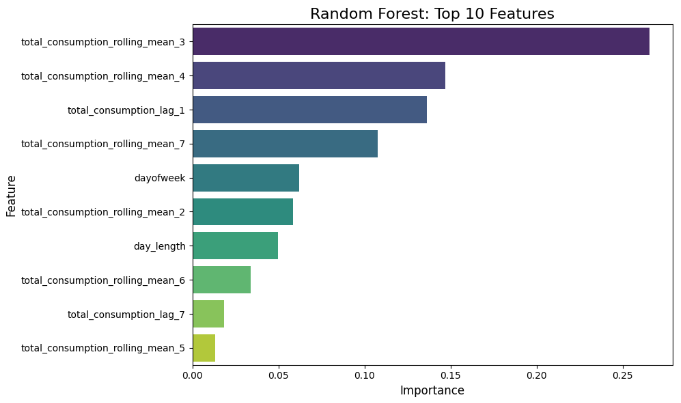

### API Implementation Code

In [80]:
class EnergyConsumptionModel:
    def __init__(self, df):
        self.target = 'total_consumption'
        self.lags = [1, 7]
        self.window_sizes = [3, 4, 5, 6, 7]
        self.created_features = []
        self.external_features = ['day_length']
        self.df = self.create_features(df)
        self.model = RandomForestRegressor(n_estimators=600, max_depth=3)
        self.train()
    
    def create_features(self, df):
        """
        Feature Engineering - Adding lag and rolling mean for specified columns.
        """
        df['dayofweek'] = df.index.dayofweek
        self.created_features.append('dayofweek')
        
        for lag in self.lags:
            feature_name = f"total_consumption_lag_{lag}"
            df[feature_name] = df['total_consumption'].shift(lag)
            self.created_features.append(feature_name)
        
        for window in self.window_sizes:
            feature_name = f"total_consumption_rolling_mean_{window}"
            df[feature_name] = df['total_consumption'].rolling(window=window).mean()
            self.created_features.append(feature_name)
        return df

    def train(self):
        """
        Trains the RandomForestRegressor model using the provided DataFrame.
        """
        features = self.created_features + self.external_features
        X_train = self.df[features]
        y_train = self.df[self.target]
        self.model.fit(X_train, y_train)

    def predict_for_date(self, date):
    #     """
    #     Predicts total consumption for a given date, ensuring features are properly prepared.
    #     """
          date = pd.to_datetime(date)
                
          if date not in self.df.index:
              print(f"No direct data available for {date}, prediction requires feature presence.")
              return None
        
          features_order = self.created_features + self.external_features
          X_test = self.df.loc[[date], features_order]
        
          if not X_test.empty:
              prediction = self.model.predict(X_test)
              return prediction[0]
          else:
              print("Features not available for prediction.")
              return None

    def predict_next_day(self):
            """
            Predicts total consumption for the day following the last date in the provided DataFrame,
            including the calculation of the dayofweek feature based on the new date.
            """
            # Find the maximum date in the DataFrame
            max_date = self.df.index.max()
            # Increment by one day to get the next day
            next_day = max_date + pd.Timedelta(days=1)
    
            # Initialize next_day_features with dayofweek for the next day
            next_day_features = {
                'dayofweek': next_day.dayofweek
            }
    
            # Assuming external features for the next day are either known or can be estimated
            # Adjust the following line if external features need specific handling
            for feature in self.external_features:
                next_day_features[feature] = self.df[feature].iloc[-1]
    
            # Prepare lag and rolling mean features based on existing data
            for lag in self.lags:
                next_day_features[f"total_consumption_lag_{lag}"] = self.df['total_consumption'].iloc[-lag]
            
            for window in self.window_sizes:
                # Calculate rolling mean for the specified 'window' ending on the 'max_date'
                next_day_features[f"total_consumption_rolling_mean_{window}"] = \
                    self.df['total_consumption'].rolling(window=window).mean().iloc[-1]
    
            # Prepare the DataFrame for prediction
            X_test = pd.DataFrame([next_day_features], index=[next_day])
    
            # Ensure features are in the correct order as expected by the model
            features_order = self.created_features + self.external_features
            X_test = X_test[features_order]
        
            # Predict total consumption for the next day
            if not X_test.empty:
                prediction = self.model.predict(X_test)
                return next_day.strftime('%d-%m-%Y'), prediction[0]
            else:
                print("Features not available for prediction.")
                return None

In [81]:
df.head(1)

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
datetime                                                                    
2006-12-16      8.2      3.4   5.7           5.7           0.6        2.9   

            dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
datetime                                                                      
2006-12-16  4.1      89.8   1.853         100        29.17   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                 
2006-12-16      39.8       19.1    235.4            1023.2        68.6   

            visibility  moonphase  conditions_clear  conditions_overcast  \
datetime                                                                   
2006-12-16        10.2       0.87             False                False   

            conditions_partiallycloudy  conditions_rain  \
datetime                                                  
2006-12-16                       False            False   

            conditions_rainovercast  conditions_rainpartiallycloudy  \
datetime                                                              
2006-12-16                    False                            True   

            conditions_snowovercast  conditions_snowpartiallycloudy  \
datetime                                                              
2006-12-16                    False                           False   

            conditions_snowrain  conditions_snowrainovercast  \
datetime                                                       
2006-12-16                False                        False   

            conditions_snowrainpartiallycloudy  day_length  total_consumption  \
datetime                                                                        
2006-12-16                               False    8.278889           1209.176   

            is_holiday  dayofweek  quarter  month  year  dayofyear  \
datetime                                                             
2006-12-16       False          5        4     12  2006        350   

            total_consumption_lag_30  total_consumption_lag_60  \
datetime                                                         
2006-12-16                       NaN                       NaN   

            total_consumption_lag_90  total_consumption_lag_365  \
datetime                                                          
2006-12-16                       NaN                        NaN   

            total_consumption_rolling_mean_30  \
datetime                                        
2006-12-16                                NaN   

            total_consumption_rolling_mean_60  \
datetime                                        
2006-12-16                                NaN   

            total_consumption_rolling_mean_90  \
datetime                                        
2006-12-16                                NaN   

            total_consumption_rolling_mean_365  temp_lag_30  temp_lag_60  \
datetime                                                                   
2006-12-16                                 NaN          NaN          NaN   

            temp_lag_90  temp_lag_365  temp_rolling_mean_30  \
datetime                                                      
2006-12-16          NaN           NaN                   NaN   

            temp_rolling_mean_60  temp_rolling_mean_90  temp_rolling_mean_365  \
datetime                                                                        
2006-12-16                   NaN                   NaN                    NaN   

            total_consumption_lag_1  total_consumption_lag_7  \
datetime                                                       
2006-12-16                      NaN                      NaN   

            total_consumption_rolling_mean_3  \
datetime                                       
2006-12-16                             

In [82]:
df.tail(1)

tempmax  tempmin  temp  feelslikemax  feelslikemin  feelslike  \
datetime                                                                    
2010-11-26      2.8     -1.1   0.5           0.4          -5.8       -3.1   

            dew  humidity  precip  precipprob  precipcover  snow  snowdepth  \
datetime                                                                      
2010-11-26 -1.3      88.3   0.091         100         12.5   0.0        0.0   

            windgust  windspeed  winddir  sealevelpressure  cloudcover  \
datetime                                                                 
2010-11-26      34.5       17.8    258.8            1007.7        66.7   

            visibility  moonphase  conditions_clear  conditions_overcast  \
datetime                                                                   
2010-11-26        13.1       0.67             False                False   

            conditions_partiallycloudy  conditions_rain  \
datetime                                                  
2010-11-26                       False            False   

            conditions_rainovercast  conditions_rainpartiallycloudy  \
datetime                                                              
2010-11-26                    False                           False   

            conditions_snowovercast  conditions_snowpartiallycloudy  \
datetime                                                              
2010-11-26                    False                           False   

            conditions_snowrain  conditions_snowrainovercast  \
datetime                                                       
2010-11-26                False                        False   

            conditions_snowrainpartiallycloudy  day_length  total_consumption  \
datetime                                                                        
2010-11-26                                True    8.741111           1488.104   

            is_holiday  dayofweek  quarter  month  year  dayofyear  \
datetime                                                             
2010-11-26       False          4        4     11  2010        330   

            total_consumption_lag_30  total_consumption_lag_60  \
datetime                                                         
2010-11-26                  1260.278                       0.0   

            total_consumption_lag_90  total_consumption_lag_365  \
datetime                                                          
2010-11-26                  1442.856                   1599.626   

            total_consumption_rolling_mean_30  \
datetime                                        
2010-11-26                        1688.914667   

            total_consumption_rolling_mean_60  \
datetime                                        
2010-11-26                          1640.7728   

            total_consumption_rolling_mean_90  \
datetime                                        
2010-11-26                        1525.821178   

            total_consumption_rolling_mean_365  temp_lag_30  temp_lag_60  \
datetime                                                                   
2010-11-26                         1514.922625         10.1         10.7   

            temp_lag_90  temp_lag_365  temp_rolling_mean_30  \
datetime                                                      
2010-11-26         16.5           9.1                  8.96   

            temp_rolling_mean_60  temp_rolling_mean_90  temp_rolling_mean_365  \
datetime                                                                        
2010-11-26             10.406667             12.257778              11.352877   

            total_consumption_lag_1  total_consumption_lag_7  \
datetime                                                       
2010-11-26                 1431.164                   1570.4   

            total_consumption_rolling_mean_3  \
datetime                                       
2010-11-26                       1571.8

In [83]:
# Call the model API
model_api = EnergyConsumptionModel(df)

In [84]:
  date = '2010-11-25'
  prediction = model_api.predict_for_date(date)
  print(f"Predicted total consumption for {date}: {prediction}")

In [85]:
next_day, next_day_prediction = model_api.predict_next_day()
print(f"Predicted total consumption for '{next_day}' (the next day): {next_day_prediction}")

Predicted total consumption for '27-11-2010' (the next day): 1654.672492897386


 effectively.

---

/ ABIR OUMGHAR

[![LinkedIn](https://img.shields.io/badge/LinkedIn-0077B5?style=flat&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/abir-oumghar-699690210/)
